<h1>T cell gating</h1>

In [2]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.gating.actions import Gating, Template
from immunova.flow.gating.defaults import ChildPopulationCollection
from warnings import filterwarnings
import pandas as pd
import os
filterwarnings('ignore')
pd_init()

In [3]:
texp = FCSExperiment.objects(experiment_id='PD_T_PDMCs').get()

In [4]:
t = Template(texp, '267-02_pdmc_t')

<h2>Gate major populations</h2>

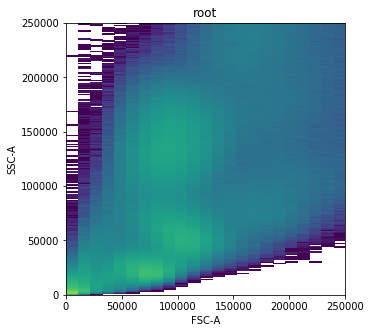

In [5]:
t.plotting.plot_population('root', 'FSC-A', 'SSC-A')

In [6]:
children = ChildPopulationCollection('geom')
children.add_population('raw_auto_cells', definition='+')
children.add_population('raw_auto_debris', definition='-')

In [7]:
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None)
t.create_gate(gate_name='raw_auto_boundary', 
              parent='root',
              class_='Static',
              method='border_gate',
              child_populations=children, 
              kwargs=kwargs)

True

In [8]:
t.gates['raw_auto_boundary'].kwargs

[['x', 'FSC-A'],
 ['y', 'SSC-A'],
 ['transform_x', None],
 ['transform_y', None],
 ['child_populations',

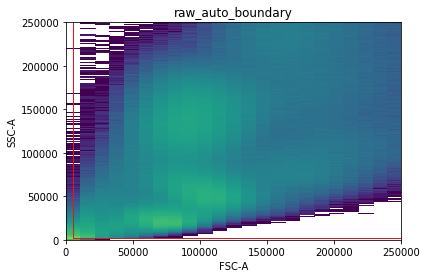

In [9]:
t.apply('raw_auto_boundary')

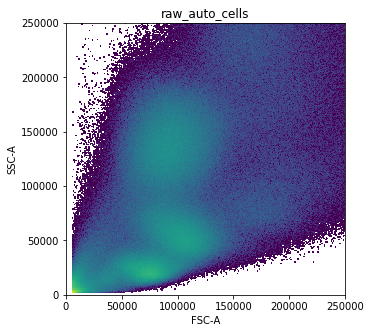

In [10]:
t.plotting.plot_population('raw_auto_cells', 'FSC-A', 'SSC-A')

In [11]:
children = ChildPopulationCollection('cluster')
children.add_population('raw_auto_lymph', target=(75000, 25000), weight=1)
kwargs = dict(x='FSC-A', y='SSC-A', transform_x=None, transform_y=None, 
              min_pop_size=50, frac=0.01)
t.create_gate(gate_name='raw_auto_lymph', 
              parent='raw_auto_cells',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)

True

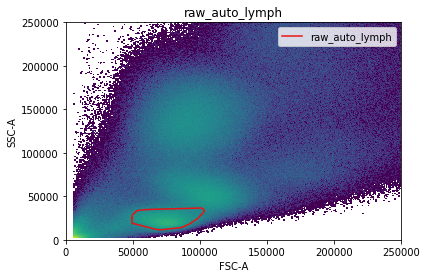

In [12]:
t.apply('raw_auto_lymph')

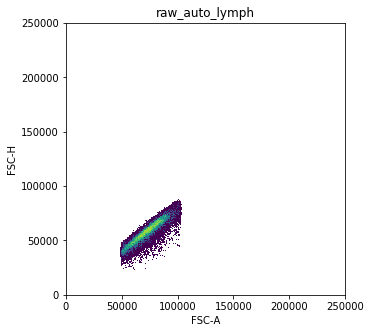

In [13]:
t.plotting.plot_population('raw_auto_lymph', 'FSC-A', 'FSC-H')

In [14]:
children = ChildPopulationCollection('geom')
children.add_population('raw_auto_singlets1', definition='+')
children.add_population('raw_auto_doublets1', definition='-')
kwargs = dict(x='FSC-A', y='FSC-H', transform_x=None, transform_y=None, target=(75000, 60000),
             conf=0.99)
t.create_gate(gate_name='raw_auto_singlets1', 
              parent='raw_auto_lymph',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)

True

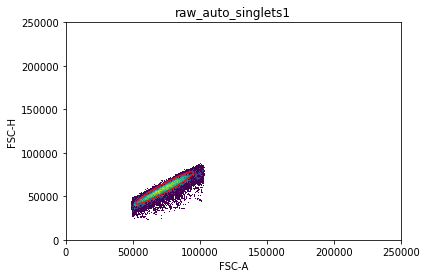

In [15]:
t.apply('raw_auto_singlets1')

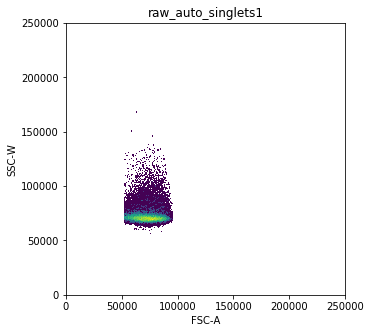

In [16]:
t.plotting.plot_population('raw_auto_singlets1', 'FSC-A', 'SSC-W')

In [17]:
children = ChildPopulationCollection('geom')
children.add_population('raw_auto_singlets2', definition='+')
children.add_population('raw_auto_doublets2', definition='-')
kwargs = dict(x='FSC-A', y='SSC-W', transform_x=None, transform_y=None, target=(75000, 70000),
             conf=0.99)
t.create_gate(gate_name='raw_auto_singlets2', 
              parent='raw_auto_singlets1',
              class_='MixtureModel',
              method='gate',
              child_populations=children, 
              kwargs=kwargs)

True

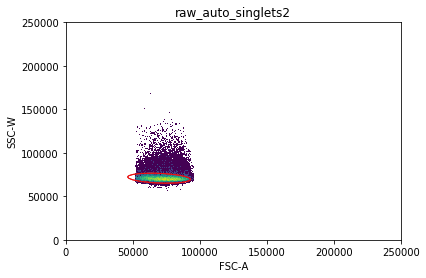

In [18]:
t.apply('raw_auto_singlets2')

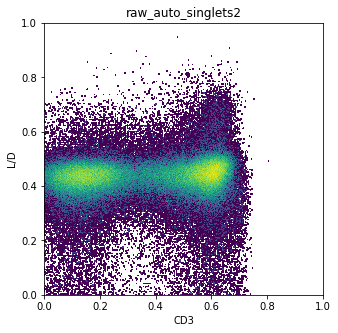

In [19]:
t.plotting.plot_population('raw_auto_singlets2', 'CD3', 'L/D', 
                           transform_x='logicle', transform_y='logicle')

In [20]:
children = ChildPopulationCollection('threshold_2d')
children.add_population('raw_auto_liveCD3', definition='+-')
children.add_population('raw_auto_dead', definition=['--', '-+', '++'])
kwargs = dict(x='CD3', y='L/D', kde_bw=0.05, q=0.95, peak_threshold=0.05)
t.create_gate(gate_name='raw_auto_liveCD3', 
              parent='raw_auto_singlets2',
              class_='DensityThreshold',
              method='gate_2d',
              child_populations=children, 
              kwargs=kwargs)

True

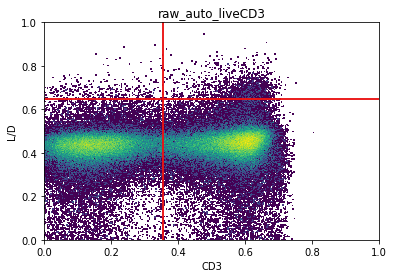

In [21]:
t.apply('raw_auto_liveCD3')

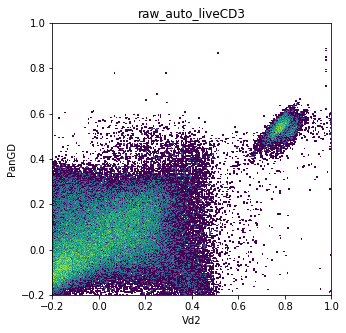

In [22]:
t.plotting.plot_population('raw_auto_liveCD3', 'Vd2', 'PanGD', 
                           transform_x='logicle', transform_y='logicle', 
                           xlim=(-0.2, 1), ylim=(-0.2, 1))

In [23]:
len(t.populations['raw_auto_liveCD3'].index)*0.2

28370.2

In [24]:
children = ChildPopulationCollection('cluster')
children.add_population('raw_auto_gdt', target=(0.8, 0.6), weight=1)
children.add_population('raw_auto_nongdt', target=(0.1, 0.1), weight=1)
kwargs = dict(x='Vd2', y='PanGD', min_pop_size=10, frac=0.2, downsample_method='density')
t.create_gate(gate_name='raw_auto_gdt', 
              parent='raw_auto_liveCD3',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)

True

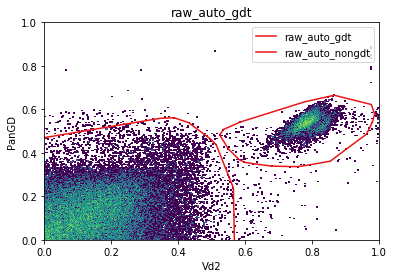

In [25]:
t.apply('raw_auto_gdt')

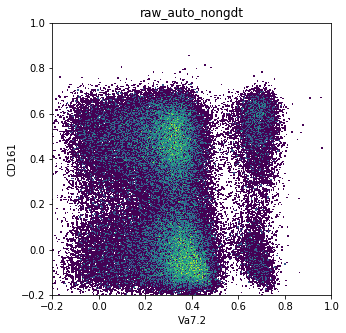

In [26]:
t.plotting.plot_population('raw_auto_nongdt', 'Va7.2', 'CD161', 
                           transform_x='logicle', transform_y='logicle', 
                           xlim=(-0.2, 1), ylim=(-0.2, 1))

In [27]:
children = ChildPopulationCollection('cluster')
children.add_population('raw_auto_mait', target=(0.8, 0.6), weight=1)
kwargs = dict(x='Va7.2', y='CD161', min_pop_size=50, frac=0.2, downsample_method='density')
t.create_gate(gate_name='raw_auto_mait', 
              parent='raw_auto_nongdt',
              class_='DensityBasedClustering',
              method='hdbscan',
              child_populations=children, 
              kwargs=kwargs)

True

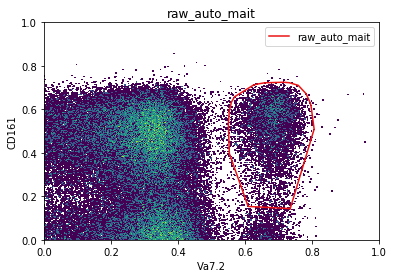

In [28]:
t.apply('raw_auto_mait')

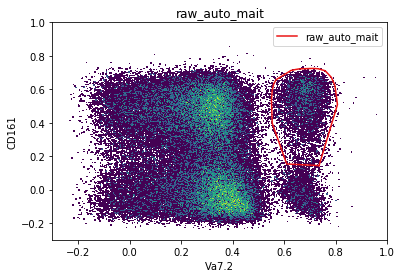

In [29]:
t.plotting.plot_gate('raw_auto_mait', xlim=(-0.3, 1), ylim=(-0.3, 1))

In [30]:
t.subtraction(target='raw_auto_mait', parent='raw_auto_nongdt', new_population_name='raw_auto_classic')

True

In [31]:
t.print_population_tree()

root
├── raw_auto_cells
│   └── raw_auto_lymph
│       ├── raw_auto_singlets1
│       │   ├── raw_auto_singlets2
│       │   │   ├── raw_auto_liveCD3
│       │   │   │   ├── raw_auto_gdt
│       │   │   │   └── raw_auto_nongdt
│       │   │   │       ├── raw_auto_mait
│       │   │   │       └── raw_auto_classic
│       │   │   └── raw_auto_dead
│       │   └── raw_auto_doublets2
│       └── raw_auto_doublets1
└── raw_auto_debris


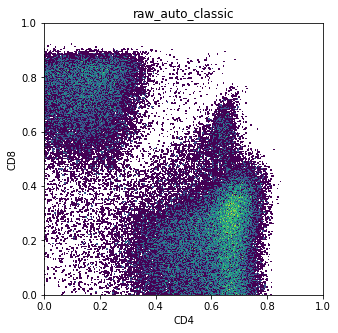

In [32]:
t.plotting.plot_population('raw_auto_classic', x='CD4', y='CD8', transform_x='logicle',
                          transform_y='logicle')

In [33]:
children = ChildPopulationCollection('threshold_2d')
children.add_population('raw_auto_cd4', definition='+-')
children.add_population('raw_auto_cd8', definition='-+')
children.add_population('raw_auto_other', definition=['--', '++'])
kwargs = dict(x='CD4', y='CD8', kde_bw=0.05, q=0.95, peak_threshold=0.05)
t.create_gate(gate_name='raw_auto_cd4cd8', 
              parent='raw_auto_classic',
              class_='DensityThreshold',
              method='gate_2d',
              child_populations=children, 
              kwargs=kwargs)

True

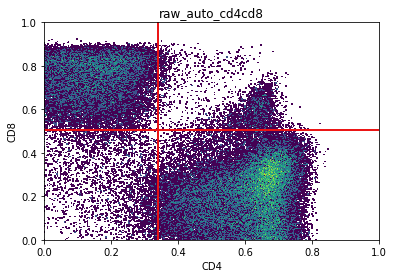

In [34]:
t.apply('raw_auto_cd4cd8')

In [35]:
t.save()

Saved successfully!


True

In [36]:
t.save_new_template('t_major_populations')

No existing template named t_major_populations, creating new template


True

<h2>FMO Gating</h2>

In [34]:
t.print_population_tree()

root
├── raw_auto_cells
│   └── raw_auto_lymph
│       ├── raw_auto_singlets1
│       │   ├── raw_auto_singlets2
│       │   │   ├── raw_auto_liveCD3
│       │   │   │   ├── raw_auto_gdt
│       │   │   │   └── raw_auto_nongdt
│       │   │   │       ├── raw_auto_mait
│       │   │   │       └── raw_auto_classic
│       │   │   │           ├── raw_auto_cd4
│       │   │   │           ├── raw_auto_cd8
│       │   │   │           └── raw_auto_other
│       │   │   └── raw_auto_dead
│       │   └── raw_auto_doublets2
│       └── raw_auto_doublets1
└── raw_auto_debris


<h3>GDTs</h3>

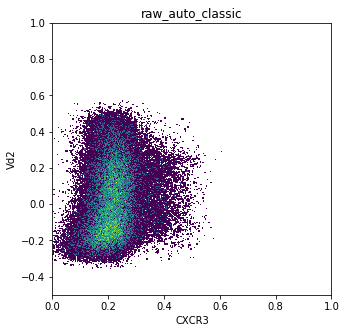

In [5]:
t.plotting.plot_population('raw_auto_classic', x='CXCR3', y='Vd2', transform_x='logicle',
                          transform_y='logicle', ylim=(-0.5, 1))

In [6]:
children = ChildPopulationCollection('threshold_1d')
children.add_population('raw_auto_cxcr3+', definition='-')
children.add_population('raw_auto_cxcr3-', definition='+')
kwargs = dict(x='CXCR3', kde_bw=0.05, q=0.95, peak_threshold=0.05, fmo_x='CXCR3')
t.create_gate(gate_name='raw_auto_gdtcxcr3', 
              parent='raw_auto_gdt',
              class_='FMOGate',
              method='gate_2d',
              child_populations=children, 
              kwargs=kwargs)

True

In [7]:
t.apply('raw_auto_gdtcxcr3')

Constructor args
{'kde_bw': 0.05, 'q': 0.95, 'peak_threshold': 0.05, 'fmo_x':                 FSC-A    FSC-H         FSC-W         SSC-A    SSC-H  \
160      74521.437500  59933.0  81488.281250  27015.720703  25789.0   
245      81554.132812  66012.0  80966.070312  16566.839844  15832.0   
468      75684.421875  62098.0  79874.625000  18307.640625  16573.0   
783      78881.039062  65477.0  78952.117188  21318.679688  19925.0   
832      79708.226562  66633.0  78395.968750  22338.679688  21405.0   
...               ...      ...           ...           ...      ...   
1616300  83555.640625  67244.0  81433.320312  17731.000000  16636.0   
1616329  67151.070312  52805.0  83340.835938  19227.000000  18065.0   
1617292  80077.406250  64928.0  80827.273438  28215.919922  25744.0   
1617396  72827.367188  59060.0  80812.976562  18625.880859  16656.0   
1617554  80694.179688  61497.0  85994.007812  29605.160156  27417.0   

                SSC-W       CXCR3        CD161           CD3        C

TypeError: __init__() missing 2 required positional arguments: 'x' and 'child_populations'

In [40]:
t.remove_gate('raw_auto_cxcr3', propagate=False)

True

In [44]:
t.gates['raw_auto_gdtcxcr3'].kwargs

[['x', 'CXCR3'],
 ['kde_bw', 0.05],
 ['q', 0.95],
 ['peak_threshold', 0.05],
 ['fmo_x', 'CXCR3'],
 ['child_populations',

In [10]:
import inspect
c = t.gating_classes['FMOGate']

In [14]:
inspect.signature(c.__bases__[0])

<Signature (kde_bw:float=0.01, ignore_double_pos:bool=False, std:float=None, q:float=0.95, peak_threshold:float=None, **kwargs)>

In [17]:
inspect.getmro(c)[0]

immunova.flow.gating.fmo.FMOGate

In [20]:
x = list(map(lambda x: inspect.signature(x).parameters.keys(), 
         [c for c in inspect.getmro(t.gating_classes['FMOGate'])]))
[l for sl in x for l in sl]

['fmo_x',
 'fmo_y',
 'z_score_threshold',
 'kwargs',
 'kde_bw',
 'ignore_double_pos',
 'std',
 'q',
 'peak_threshold',
 'kwargs',
 'data',
 'x',
 'child_populations',
 'y',
 'frac',
 'downsample_method',
 'density_downsample_kwargs',
 'transform_x',
 'transform_y',
 'low_memory']